# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. 

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`: 
- *text* - в нём содержит текст комментария
- *toxic* - целевой признак

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer 

import re
from tqdm import tqdm

В работе будет применятся модель NBSVM, принципы модели описаны в [Baselines and Bigrams: Simple, Good Sentiment and Topic Classification](https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf)

In [2]:
class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, tol=1e-3, 
                 max_iter=1000, random_state=None, 
                 class_weight=None):
        self.C = C
        self.tol = tol
        self.max_iter = max_iter
        self.random_state = random_state
        self.class_weight = class_weight

    def predict(self, x):
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LinearSVC(random_state=self.random_state, 
                              class_weight=self.class_weight,  
                              C=self.C, 
                              tol=self.tol,
                              max_iter=self.max_iter).fit(x_nb, y)
        return self

### Общая информация о данных

In [3]:
try:
    data = pd.read_csv("D:\\Yandex_practicum\\Project_15_texts_toxic_comments\\toxic_comments.csv", usecols=['text', 'toxic'])
except:    
    data = pd.read_csv("/datasets/toxic_comments.csv", usecols=['text', 'toxic'])

In [4]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Пример токсичного комментария

In [6]:
data.loc[data['toxic'] == 1]['text'].sample().values[0]

"There are multiple sources to go to pal....... \n\nYou go to one music source on the internet and that's the be all end all. There are many sources to go to in order to find info on Allin and T.T. Quick........You could just buy the albums and look at them. I guess you're one of those people who are just experts on every subject, right!   What else do you do on your computer all day?  I wonder!  You're full of shit.........and you know it!"

Пример обычного комментария

In [7]:
data.loc[data['toxic'] == 0]['text'].sample().values[0]

'"\n\n Help with ""Turing\'s Proof"" page \n\nHi, I could use some edit help with the ""Turing\'s Proof"" page, especially ""proof #3"". (This page is meant to be interpretive, synoptic, i.e. I don\'t consider it ""original work""). wvbailey "'

In [8]:
sns.set_style('whitegrid')

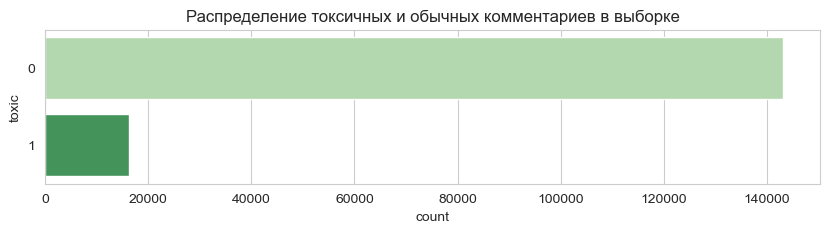

In [9]:
plt.figure(figsize=(10,2))
sns.countplot(y=data['toxic'],
              orient='h',
              palette='Greens');
plt.title('Распределение токсичных и обычных комментариев в выборке');

In [10]:
data['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

### Предобработка данных и добавление новых признаков

Ведем ряд признаков

In [11]:
%%time
data['total_length'] = data['text'].apply(len)
data['capitals'] = data['text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
data['caps_vs_length'] = data['capitals'] / data['total_length']
data['num_exclamation_marks'] = data['text'].apply(lambda comment: comment.count('!'))
data['exc_vs_length'] = data['num_exclamation_marks'] / data['total_length']
data['num_question_marks'] = data['text'].apply(lambda comment: comment.count('?'))
data['que_vs_length'] = data['num_question_marks'] / data['total_length']
data['num_punctuation'] = data['text'].apply(lambda comment: sum(comment.count(w) for w in '.,;:'))
data['num_symbols'] = data['text'].apply(lambda comment: sum(comment.count(w) for w in '*&$%'))
data['sym_vs_length'] = data['num_symbols'] / data['total_length']

CPU times: total: 3.75 s
Wall time: 3.87 s


Проведем лемматизацию данных

In [12]:
nltk.download('wordnet')
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\arrr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arrr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
def lemmatize(text):
    
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.split()
    text = " ".join(text)
    
    word_list = nltk.word_tokenize(text)
    lemmatized_out = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    
    return lemmatized_out

In [14]:
tqdm.pandas()

In [15]:
%%time
data['text'] = data['text'].progress_apply(lemmatize)

100%|██████████| 159292/159292 [01:15<00:00, 2116.52it/s]

CPU times: total: 40.8 s
Wall time: 1min 15s


Добавим еще признаков

In [16]:
%%time
data['num_words'] = data['text'].apply(lambda comment: len(comment.split()))
data['num_unique_words'] = data['text'].apply(lambda comment: len(set(w for w in comment.split())))
data['words_vs_unique'] = data['num_unique_words'] / data['num_words']
data['uni_vs_length'] = data['num_unique_words'] / data['total_length']
data['sym_vs_uni'] = data['num_symbols'] / data['num_unique_words']
data['w_vs_length'] = data['num_words'] / data['total_length']
data['exc_vs_uni'] = data['num_exclamation_marks'] / data['num_unique_words']
data['caps_vs_words'] = data['capitals'] / data['num_words']

CPU times: total: 2.28 s
Wall time: 2.48 s


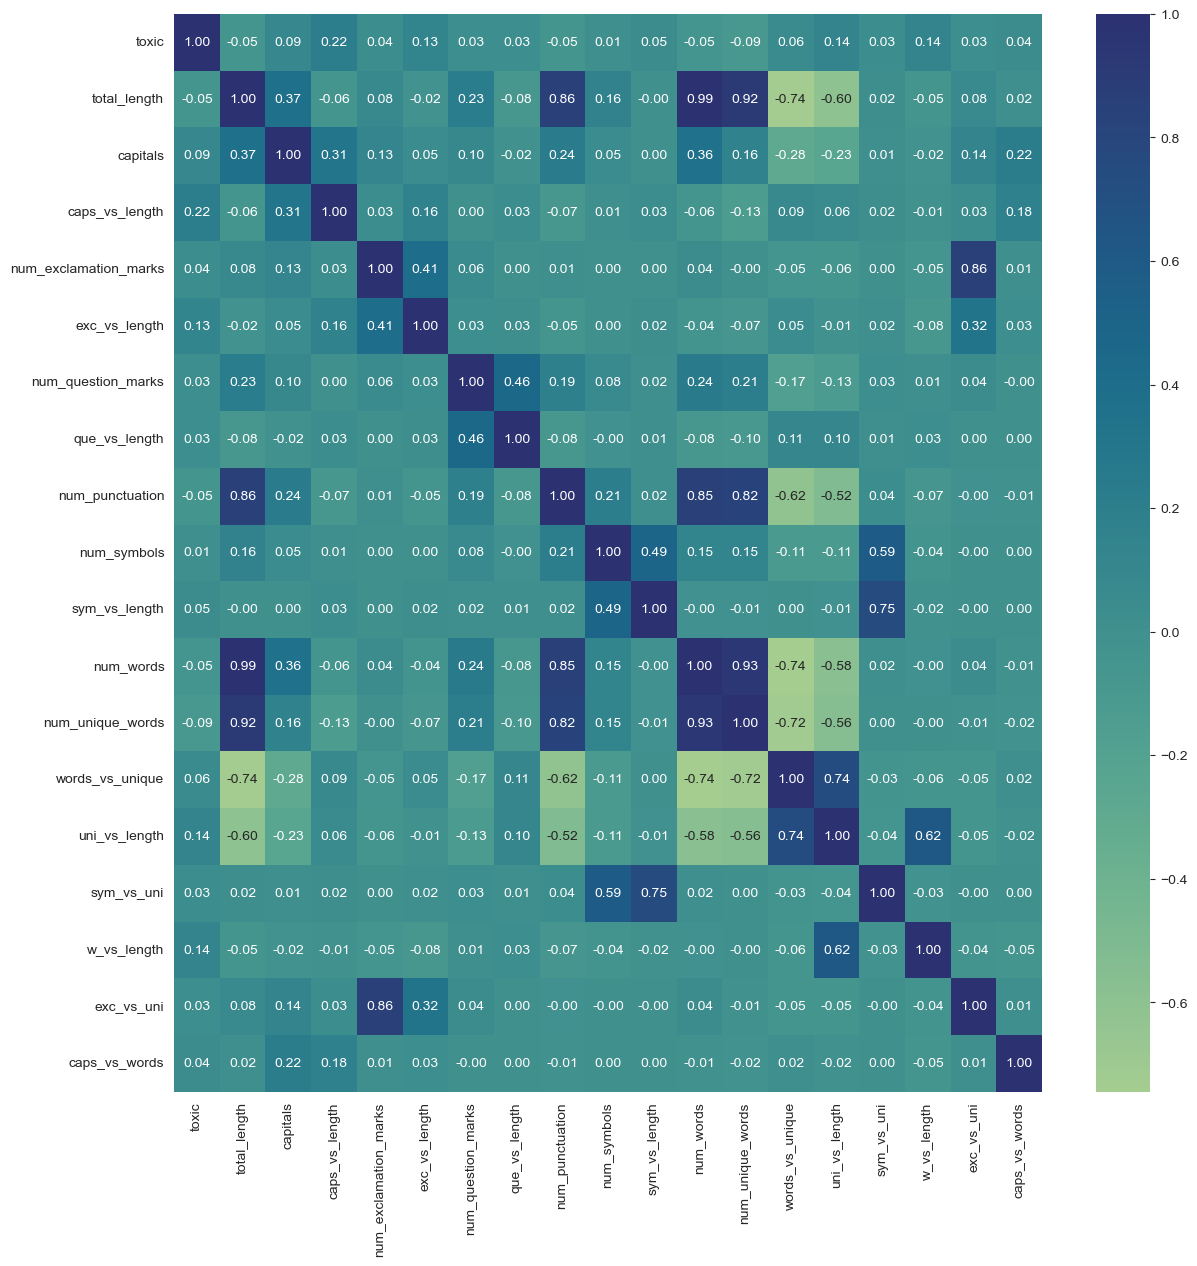

In [17]:
plt.figure(figsize=(14, 14))
sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='crest');

Удалим дубликаты и пустые строки из данных, которые появились после лемматизации

In [18]:
data['text'].duplicated().sum()

1181

In [19]:
data[data['text'].duplicated(keep=False)]['text'].sort_values().tail(10)

149790    wikipedia s censorship I looked up Bash Back T...
89730     wikipedia s censorship I looked up Bash Back T...
63210     wow and now i bet u feel like a big man on wik...
62199     wow and now i bet u feel like a big man on wik...
90495     yeah is that youuu oh i think it is big boi ye...
18763     yeah is that youuu oh i think it is big boi ye...
56707     you both are little faggot with no life so may...
54194     you both are little faggot with no life so may...
56435     zionist jew please stop spreadin your lie bias...
94426     zionist jew please stop spreadin your lie bias...
Name: text, dtype: object

In [20]:
data = data[data['text'] != '']

In [21]:
data.drop_duplicates(subset=['text'], inplace=True, ignore_index=True)

In [22]:
data['text'].duplicated().sum()

0

In [23]:
data.head()

,text,toxic,total_length,capitals,caps_vs_length,num_exclamation_marks,exc_vs_length,num_question_marks,que_vs_length,num_punctuation,num_symbols,sym_vs_length,num_words,num_unique_words,words_vs_unique,uni_vs_length,sym_vs_uni,w_vs_length,exc_vs_uni,caps_vs_words
0,Explanation Why the edits made under my userna...,0,264,17,0.064394,0,0.000000,1,0.003788,6,0,0.0,46,42,0.913043,0.159091,0.0,0.174242,0.0000,0.369565
1,D aww He match this background colour I m seem...,0,112,8,0.071429,1,0.008929,0,0.000000,5,0,0.0,16,16,1.000000,0.142857,0.0,0.142857,0.0625,0.500000
2,Hey man I m really not trying to edit war It s...,0,233,4,0.017167,0,0.000000,0,0.000000,4,0,0.0,44,41,0.931818,0.175966,0.0,0.188841,0.0000,0.090909
3,More I can t make any real suggestion on impro...,0,622,11,0.017685,0,0.000000,0,0.000000,6,0,0.0,116,83,0.715517,0.133441,0.0,0.186495,0.0000,0.094828
4,You sir are my hero Any chance you remember wh...,0,67,2,0.029851,0,0.000000,1,0.014925,3,0,0.0,14,14,1.000000,0.208955,0.0,0.208955,0.0000,0.142857


### Разбиение на выборки

In [24]:
features = data.drop(columns=['toxic'])

In [25]:
target = data['toxic']

In [26]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target,
                                                                            test_size=0.2,
                                                                            random_state=27,
                                                                            stratify=target)

In [27]:
#check
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(126488, 19)
(126488,)
(31622, 19)
(31622,)


Выделим из обучающей выборки часть для подбора параметров и кросс-валидации для экономии времени

In [28]:
sample_features, _, sample_target, _ = train_test_split(features_train, 
                                                        target_train,
                                                        train_size=0.3,
                                                        random_state=27,
                                                        stratify=target_train)

In [29]:
#check
print(sample_features.shape)
print(sample_target.shape)

(37946, 19)
(37946,)


### Pipeline

In [30]:
count_tf_idf_word = TfidfVectorizer(stop_words=stopwords)
count_tf_idf_char = TfidfVectorizer(stop_words=stopwords, analyzer='char')
scaler = MinMaxScaler()

In [31]:
word_transformer = ColumnTransformer(transformers=[('w', count_tf_idf_word, 'text')])
char_transformer = ColumnTransformer(transformers=[('c', count_tf_idf_char, 'text')])
num_transformer = ColumnTransformer(transformers=[('n', scaler, selector(dtype_exclude='object'))])

In [32]:
vectorizer = FeatureUnion([('word', word_transformer), ('char', char_transformer), ('num', num_transformer)])

In [33]:
pipe_svm = Pipeline([('transform', vectorizer),
                     ('classifier', LinearSVC(random_state=27, class_weight='balanced'))])

In [34]:
pipe_nbsvm = Pipeline([('transform', vectorizer),
                       ('classifier', NbSvmClassifier(random_state=27, class_weight='balanced'))])

## Подбор параметров и обучение лучшей модели

### LinearSVC

In [35]:
params = {
   'transform__word__w__max_features' : [250000, 150000], 
    'transform__word__w__ngram_range' : [(1,2), (1,3)],
    'transform__char__c__max_features' : [250000, 150000],
    'transform__char__c__ngram_range' : [ (3,6), (3,7)],
    'classifier__tol' : np.linspace(1e-7, 1e-5, 10),
    'classifier__C' : np.linspace(0.1, 1.5, 10)
}

In [36]:
search_svm = RandomizedSearchCV(pipe_svm,
                                param_distributions=params,
                                n_iter=10,
                                cv=3,
                                refit=False,
                                scoring='f1',
                                random_state=27,
                                pre_dispatch=10,
                                n_jobs=-1,
                                verbose=1)

In [37]:
search_svm.fit(sample_features, sample_target);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [38]:
print(f'Лучшая метрика на кросс-валидации f1 - {search_svm.best_score_:0.3f}')

Лучшая метрика на кросс-валидации f1 - 0.776


In [39]:
print('Лучшие параметры модели')
search_svm.best_params_

Лучшие параметры модели


{'transform__word__w__ngram_range': (1, 2),
 'transform__word__w__max_features': 250000,
 'transform__char__c__ngram_range': (3, 6),
 'transform__char__c__max_features': 250000,
 'classifier__tol': 7.800000000000002e-06,
 'classifier__C': 0.7222222222222222}

In [40]:
pipe_svm.set_params(**search_svm.best_params_);

По результатам кросс-валидации модель удовлетворяет целям проекта

### NBSVM

In [41]:
search_nbsvm = RandomizedSearchCV(pipe_nbsvm,
                                  param_distributions=params,
                                  n_iter=10,
                                  cv=3,
                                  refit=False,
                                  scoring='f1',
                                  random_state=27,
                                  pre_dispatch=10,
                                  n_jobs=-1,
                                  verbose=1)

In [42]:
search_nbsvm.fit(sample_features, sample_target);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [43]:
print(f'Лучшая метрика на кросс-валидации f1 - {search_nbsvm.best_score_:0.3f}')

Лучшая метрика на кросс-валидации f1 - 0.792


In [44]:
print('Лучшие параметры модели')
search_nbsvm.best_params_

Лучшие параметры модели


{'transform__word__w__ngram_range': (1, 3),
 'transform__word__w__max_features': 250000,
 'transform__char__c__ngram_range': (3, 7),
 'transform__char__c__max_features': 150000,
 'classifier__tol': 8.900000000000001e-06,
 'classifier__C': 0.1}

In [45]:
pipe_nbsvm.set_params(**search_nbsvm.best_params_);

In [46]:
pd.DataFrame([search_svm.best_score_, search_nbsvm.best_score_],
             index=['LinearSVC', 'NBSVM'],
             columns=['F1'])

,F1
LinearSVC,0.776140
NBSVM,0.792213


По результатам кросс-валидации лучшее значение метрики у NBSVM, обучать и тестировать будем ее

In [47]:
pipe_nbsvm.fit(features_train, target_train);

## Тестирование

In [48]:
predictions = pipe_nbsvm.predict(features_test)

In [49]:
print(classification_report(target_test, predictions))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98     28407
           1       0.79      0.85      0.82      3215

    accuracy                           0.96     31622
   macro avg       0.89      0.91      0.90     31622
weighted avg       0.96      0.96      0.96     31622



In [50]:
print(f'f1-мера лучшей модели на тестовой выборке - {f1_score(target_test, predictions):0.3f}')

f1-мера лучшей модели на тестовой выборке - 0.819


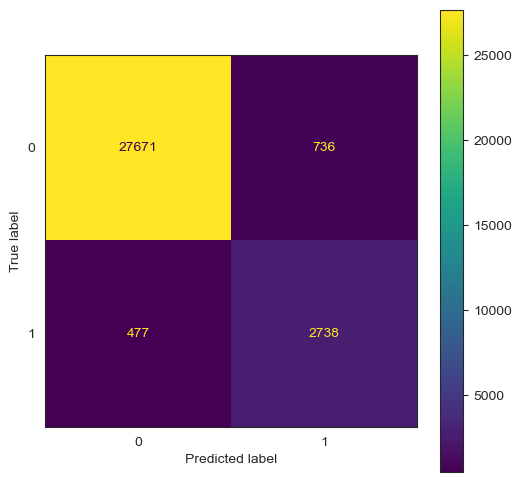

In [51]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(6,6))
ConfusionMatrixDisplay(confusion_matrix(target_test, predictions)).plot(ax=ax);

## Выводы

- Проведена лемматизация текстовых данных
- Из текстовых данных созданы признаки методом TF-IDF
- Выбрана модель с лучшими показателями при кросс-валидации - NBSVM
- Проведена проверка модели на тестовой выборке, итоговое значение целевой метрики f1 соответствует целям проекта
- Добавление численных признаков и двойной TF-IDF дали прирост к итоговой метрике 0.03
- Применение NBSVM увеличило итоговую метрику на 0.01